In [1]:
################################################################################
#########################    Regression: SVM - MLP    ##########################
################################################################################
### Load necessary modules -------------------------------
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
plt.style.use('ggplot')
import RegressionTools as RT
import numpy as np
import neuralsens as ns
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='diagram')

In [2]:
### Load file --------------------------------------------
df = pd.read_csv('DAILY_DEMAND.csv', sep = ";")
df.head()

,fecha,DEM,WD,TEMP
0,01/07/2007,590.803564,7,23.100
1,02/07/2007,738.568372,1,22.650
2,03/07/2007,774.875745,2,23.275
3,04/07/2007,783.546441,3,24.375
4,05/07/2007,771.248135,4,21.675


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   1980 non-null   object 
 1   DEM     1980 non-null   float64
 2   WD      1980 non-null   int64  
 3   TEMP    1980 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 62.0+ KB


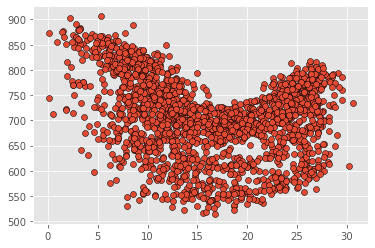

In [4]:
# Output variable (TMIN MADRID-RETIRO)
plt.scatter(x=df.TEMP, y=df.DEM, edgecolor='black')
plt.show()

In [5]:
### Convert necessary variable to factor
df.WD = df.WD.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   fecha   1980 non-null   object  
 1   DEM     1980 non-null   float64 
 2   WD      1980 non-null   category
 3   TEMP    1980 non-null   float64 
dtypes: category(1), float64(2), object(1)
memory usage: 48.8+ KB


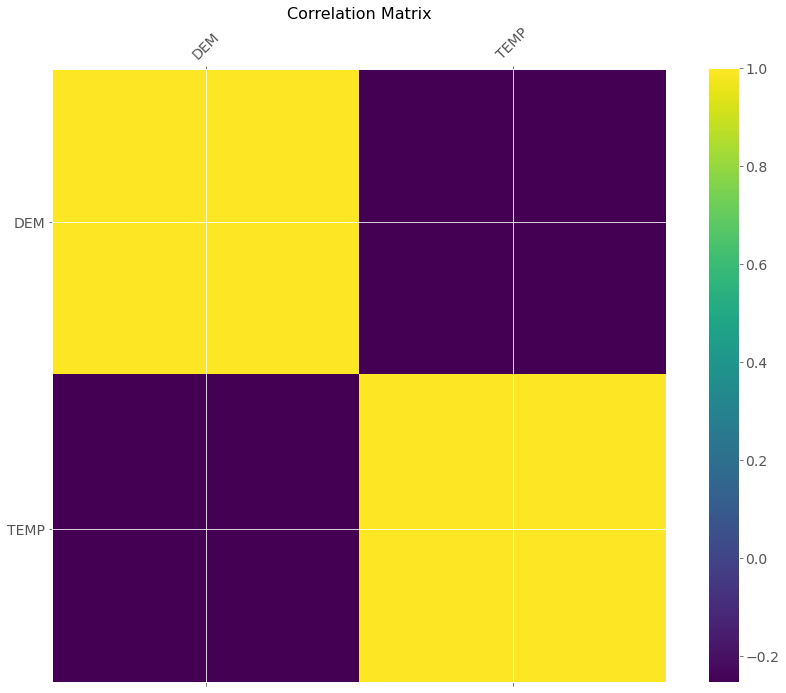

In [6]:
#correlation plot of numeric variables
f = plt.figure(figsize=(15, 11))
plt.matshow(df.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


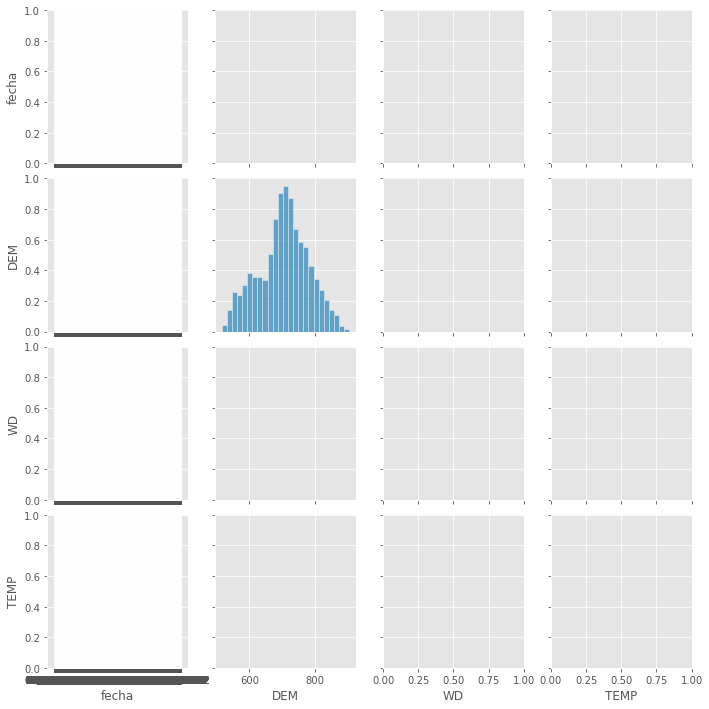

In [7]:
### Exploratory analysis -------------------------------------------------------------------------------------
sns.pairplot(df, vars=df.columns.values.tolist())
plt.show()

In [8]:
#To analyze in greater detail the relation between inputs and output, use PlotDataframe function
RT.PlotDataframe(df, 'DEM', spline_degree=3)

KeyboardInterrupt: 

In [ ]:
X = df.loc[:, [name not in ['fecha','DEM'] for name in df.columns.values.tolist()]]
y = df['DEM']
## Divide the data into training and test sets ---------------------------------------------------
## Create random 80/20 % split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['DEM'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['DEM'] = y_test

In [ ]:
#-------------------------------------------------------------------------------------------------
#--------------------------------------- SVR MODEL -----------------------------------------------
#-------------------------------------------------------------------------------------------------
# Prepare the numeric variables by imputing by its median and scaling
# numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.values.tolist()
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.values.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Prepare the categorical variables by imputing by last value and encoding the categories
categorical_features = X_train.select_dtypes(include=['category']).columns.values.tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])

param = {'SVR__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]} # Cost term
pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('SVR', SVR())
        ])
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
SVR_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
SVR_fit.fit(X_train[numeric_features + categorical_features], y_train) # Search in grid

# Plot the cross validation score (accuracy) in the Grid Search
nFolds = 10
cv_errors = np.empty([nFolds,len(SVR_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = SVR_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_SVR = meanAcc # Store cv-scores for later


plt.figure(figsize=(12, 6))
plt.plot(SVR_fit.cv_results_['param_SVR__C'], meanAcc, marker='o', color='navy', markersize=10)
plt.errorbar(SVR_fit.cv_results_['param_SVR__C'], meanAcc, yerr=stdAcc, linestyle="None", ecolor='lightblue')
plt.plot(SVR_fit.best_params_['SVR__C'], SVR_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate C Value. Best model with ' + str(SVR_fit.best_params_['SVR__C']) + ' C')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['SVR_pred'] = SVR_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['SVR_pred'] = SVR_fit.predict(X_test)

### Plot predictions of the model
sns.scatterplot(x='TEMP', y='DEM', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='SVR_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TEMP', y='DEM', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='SVR_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

In [ ]:
### Plot predictions of the model coloring by weekday
sns.scatterplot(x='TEMP', y='DEM', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='SVR_pred', data=dfTR_eval, hue='WD', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TEMP', y='DEM', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='SVR_pred', data=dfTS_eval, hue='WD', edgecolor='black').set_title('Predictions for training data')
plt.show()

In [ ]:
#-------------------------------------------------------------------------------------------------
#--------------------------------------- MLP MODEL -----------------------------------------------
#-------------------------------------------------------------------------------------------------
# Prepare the numeric variables by imputing by its median and scaling
# numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.values.tolist()
numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.values.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Prepare the categorical variables by imputing by last value and encoding the categories
categorical_features = X_train.select_dtypes(include=['category']).columns.values.tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ])

param = {'MLP__learning_rate_init': [0.01,0.1,1], # Initial value of learning rate 
         'MLP__hidden_layer_sizes':[(20,),(25,),(30,),(35,),]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('MLP', MLPRegressor(solver='adam', # Update function
                                activation='logistic', # Logistic sigmoid activation function
                                alpha=0.01, # L2 regularization term
                                learning_rate='adaptive', # Type of learning rate used in training
                                max_iter=250, # Maximum number of iterations
                                batch_size=10, # Size of batch when training
                                tol=1e-4, # Tolerance for the optimization
                                validation_fraction=0.0, # Percentage of samples used for validation
                                n_iter_no_change=10, # Maximum number of epochs to not meet tol improvement
                                random_state=150))
        ])
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[numeric_features + categorical_features], y_train) # Search in grid

# Plot the cross validation score (accuracy) in the Grid Search
nFolds = 10
cv_errors = np.empty([nFolds,len(MLP_fit.cv_results_['split0_test_score'])])
for split in range(nFolds):
    cv_errors[split,:] = MLP_fit.cv_results_['split' + str(split) + '_test_score']
meanAcc = cv_errors.mean(0)
stdAcc = cv_errors.std(0)

scores_MLP = meanAcc # Store cv-scores for later



plt.figure(figsize=(12, 6))
plt.errorbar(MLP_fit.cv_results_['param_MLP__learning_rate_init'], 
             [x for _,x in sorted(zip(MLP_fit.cv_results_['param_MLP__learning_rate_init'],meanAcc))], 
             yerr=[x for _,x in sorted(zip(MLP_fit.cv_results_['param_MLP__learning_rate_init'],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter(MLP_fit.cv_results_['param_MLP__learning_rate_init'], 
            [x for _,x in sorted(zip(MLP_fit.cv_results_['param_MLP__learning_rate_init'],meanAcc))], 
            c=[a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="Number of neurons")
plt.plot(MLP_fit.best_params_['MLP__learning_rate_init'], MLP_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate learning rate Value. Best model with ' + str(MLP_fit.best_params_['MLP__learning_rate_init']) + ' learning rate')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.show()

plt.figure(figsize=(12, 6))
plt.errorbar([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']], 
             [x for _,x in sorted(zip([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],meanAcc))], 
             yerr=[x for _,x in sorted(zip([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],stdAcc))], 
             linestyle="None", ecolor='lightblue')
sct = plt.scatter([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']], 
            [x for _,x in sorted(zip([a[0] for a in MLP_fit.cv_results_['param_MLP__hidden_layer_sizes']],meanAcc))], 
            c=np.log10(np.array([a for a in MLP_fit.cv_results_['param_MLP__learning_rate_init']],dtype=float)),s=100)
plt.legend(*sct.legend_elements(), loc="lower right", title="Learning rate")
plt.plot(MLP_fit.best_params_['MLP__hidden_layer_sizes'][0], MLP_fit.best_score_,marker='o', markersize=15, color='red')
plt.title('Accuracy Rate layer size Value. Best model with ' + str(MLP_fit.best_params_['MLP__hidden_layer_sizes'][0]) + ' neurons')
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.show()
MLP_fit

In [10]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train).toarray() # Preprocess the variables
if X_train.select_dtypes('category').shape[1] > 0:
    column_init = X_train.select_dtypes(exclude='category').shape[1]
    input_names = []
    for cat_input in X_train.select_dtypes('category').columns:
        input_names += [cat_input + str(cat) for cat in X_train[cat_input].unique()]
    coefnames = X_train.select_dtypes(exclude='category').columns.values.tolist() + input_names
else:
    coefnames = X_train.columns.values.tolist()

X = pd.DataFrame(X, columns=coefnames)
y = y_train
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

NameError: name 'MLP_fit' is not defined

In [ ]:
sensmlp = ns.SensAnalysisMLP(wts, bias, actfunc, X, y)

In [ ]:
sensmlp.summary()

In [ ]:
sensmlp.info()

In [ ]:
sensmlp.plot()

In [ ]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

### Plot predictions of the model
sns.scatterplot(x='TEMP', y='DEM', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TEMP', y='DEM', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

In [ ]:
### Plot predictions of the model coloring by weekday
sns.scatterplot(x='TEMP', y='DEM', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='MLP_pred', data=dfTR_eval, hue='WD', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TEMP', y='DEM', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TEMP', y='MLP_pred', data=dfTS_eval, hue='WD', edgecolor='black').set_title('Predictions for training data')
plt.show()